# Surface tension calculations using DFT for Helium-Para-Hydrogen mixtures
Classical density functional theory for interfacial properties of hydrogen, helium, deuterium, neon and their mixtures ([doi:10.1063/5.0137226](https://doi.org/10.1063/5.0137226))

In [1]:
from feos import *
from feos.si import *
from feos.dft import *
from feos.saftvrqmie import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
import seaborn as sns
import tqdm
import json

sns.set_context('talk')
sns.set_palette('Dark2')
sns.set_style('ticks')

# Set up FEOS functional

In [2]:
parameters = SaftVRQMieParameters.from_json(["helium", "para-hydrogen"], 
                                            "../../parameters/saftvrqmie/hammer2023.json",
                                            binary_path="../../parameters/saftvrqmie/aasen2020_binary.json")
eos = HelmholtzEnergyFunctional.saftvrqmie(parameters)

## Critcal temperature estimate

In [3]:
cp = State.critical_point(eos, np.array([0.5, 0.5]) * MOL, initial_temperature=35*KELVIN)

# Utility functions

In [4]:
def density_error(x_he, T, eos, rho_he_spec):
    """Evaluate relative error in partial density for helium"""
    x = np.array([x_he[0]/1000, 1-x_he[0]/1000])
    vle_guess = PhaseEquilibrium.bubble_point(eos, T * KELVIN, x)
    rho_he = vle_guess.vapor.partial_density[0] / MOL * METER**3
    error = (rho_he_spec - rho_he)/rho_he_spec
    return error

def surftens_mulero2012(param, tr):
    """
    Calculate pure fluid surface tension A(1-tr)**(B+C*tr+D*tr**2)
    Args:
        param (np.ndarray): 
        tr (np.ndarray): Reduced temperature
    Returns:
        sigma (np.ndarray): Surface tension (mN/m)
    """
    A = param[0]
    exponent = np.zeros_like(tr)
    exponent[:] = param[1]
    for i in range(2,len(param)):
        exponent += param[i]*tr**(i-1)
    sigma = A*(1-tr)**exponent
    return sigma * NEWTON / METER / (MILLI * NEWTON/  METER)

# Load experimental data and set some constants
Paine and Seidel.
*Surface energy of liquid hydrogen with adsorbed helium.*
Phys. Rev. B, 1992.

In [5]:
data = np.loadtxt("./data/hydrogen_helium_exp_data.dat", skiprows=1)
mw_he = 4.002602 # g/mol
Temperatures = np.unique(data[:, 0])
tc_hydrogen = 32.938

# Polynomial $x_\rm{He}(\rho_\rm{He}) \times 1000$ along Pxy curve

In [6]:
polynomialfit = {}
polynomialfit["15"] = np.poly1d([3.70595985e-13,-2.52616512e-08,1.15152761e-03, 1.49408651e-02])
polynomialfit["17"] = np.poly1d([4.70776561e-13, -3.14841235e-08,  1.71167557e-03,  1.40996915e-02])
polynomialfit["19"] = np.poly1d([5.62549441e-13, -3.60963365e-08,  2.41768533e-03,  1.25644080e-02])
polynomialfit["21"] = np.poly1d([6.20734538e-13, -3.70971572e-08,  3.30504009e-03,  1.23204963e-02])

# Find helium vapor composition, $x_{\rm{max}}$, given $\rho_{\rm{He}} (x_{\rm{max}})$ = $\rho_{\rm{max}}$

In [7]:
rho_max = 10000.0
x_max = []
x_he_fun_of_rho = {}
for T in tqdm.tqdm(Temperatures):
    x0 = polynomialfit[str(int(T))](rho_max)
    # Solve for rho_he(x) = rho_max
    x = fsolve(density_error, x0, args=(T, eos, rho_max))
    x_max.append(x[0]/1000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.01s/it]


# Map isotherms to $x_{\rm{he}}=x_{\rm{max}}$

In [8]:
states = []
for i, T in enumerate(tqdm.tqdm(Temperatures)):
    xa = np.linspace(1.0e-8, x_max[i], 20)
    T_states = []
    for x in xa:
        x_sol = np.array([x, 1-x])
        state = PhaseEquilibrium.bubble_point(eos, T * KELVIN, x_sol)
        T_states.append(state)
    states.append(T_states)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.94s/it]


# Calculate and plot surface tension along the isotherms

In [9]:
gamma = []
for T_states in tqdm.tqdm(states):
    gamma_T = []
    for state in T_states:
        gamma_T.append(PlanarInterface.from_tanh(state, 1024, 200 * ANGSTROM, cp.temperature).solve().surface_tension / (MILLI  * NEWTON / METER))
    gamma.append(gamma_T)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:14<00:00, 33.56s/it]


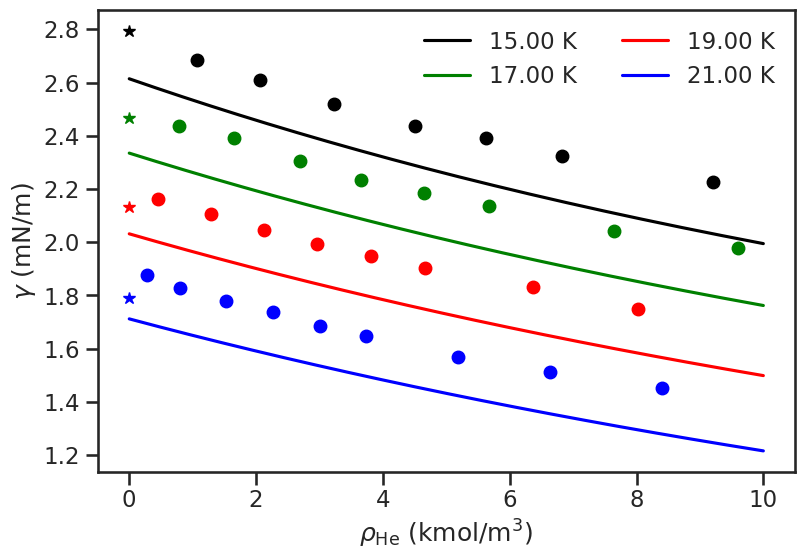

In [10]:
plt.figure(figsize=(9, 6))
colors = ["k","g","r","b","grey","orange","cyan"]
for i, T in enumerate(Temperatures):
    rho = []
    for state in states[i]:
        rho.append(state.vapor.partial_density[0] / MOL * METER**3)
    plt.plot(np.array(rho)/1000, gamma[i], label=f"{T:.2f} K", color=colors[i])
    rho_exp = data[np.isclose(data[:, 0], T, atol=0.001),1] / mw_he * 1e6
    sur_tens_exp = data[np.isclose(data[:, 0], T, atol=0.001),2]
    plt.plot(rho_exp/1000, sur_tens_exp, linestyle="None", marker="o", color=colors[i])
    tr = np.array([T/tc_hydrogen])
    s_corr = surftens_mulero2012([0.00471037, 0.62668507, 0.51110266], tr)
    plt.plot([0.0], s_corr, "*", color=colors[i])    
    
plt.xlabel(r'$\rho_{\rm{He}}$ (kmol/m$^3$)')
plt.ylabel(r'$\gamma$ (mN/m)')
leg = plt.legend(loc='best', ncol=2, frameon=False)

# Calculate composition given partial helium density of each experimental point

In [11]:
exp_states = []
for T in tqdm.tqdm(Temperatures):
    # Loop all experiments on current temperature
    data_T = data[np.isclose(data[:,0],T),1:3]
    for j in range(np.shape(data_T)[0]):
        rho_he_j = data_T[j,0] / mw_he * 1e6
        surftens_exp = data_T[j,1]
        # Interpolate to get initial guess, x0: rho_he(x0) ~= rho_he_j
        x0 = polynomialfit[str(int(T))](rho_he_j)
        # Solve for rho_he(x) = rho_he_j
        x = fsolve(density_error, x0, args=(T, eos, rho_he_j))
        exp_states.append([x[0]/1000, surftens_exp, T])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.61s/it]


# Calculate state and surface tension for the experimental points

In [12]:
states = []
for x, s_exp, T in tqdm.tqdm(exp_states):
    x_sol = np.array([x, 1-x])
    state = PhaseEquilibrium.bubble_point(eos, T * KELVIN, x_sol)
    states.append([state, s_exp, T])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.26it/s]


In [13]:
sft = []
for state, s_exp, T in tqdm.tqdm(states):
    sft.append({
        "dft": PlanarInterface.from_tanh(state, 1024, 200 * ANGSTROM, cp.temperature).solve().surface_tension / (MILLI  * NEWTON / METER), 
        "exp": s_exp,
        "T": T}
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [01:18<00:00,  2.46s/it]


# Calculate mean absolute deviation (MAD)

In [14]:
df = pd.DataFrame(sft)
mad = 100*np.sum(np.abs((df.dft-df.exp)/df.exp))/df.exp.shape[0]
print(f"MAD={mad:.1f} %")

MAD=8.1 %


# Plot error map

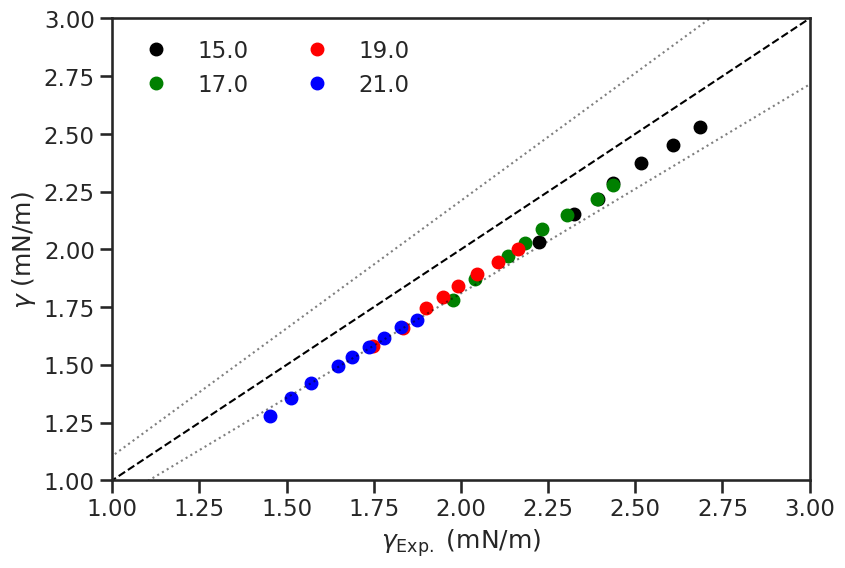

In [15]:
plt.figure(figsize=(9, 6))
smax = 3
err_fan = 0.1
groups = df.groupby('T')
for i, res in enumerate(groups):
    name=res[0]
    group=res[1]
    plt.plot(group.exp, group.dft, "o", color=colors[i], label=str(name))
plt.plot([0, smax], [0, smax], color="black", linestyle="dashed", alpha=1.0, lw=1.5)
plt.plot([0, smax*(1+err_fan/2)], [0, smax*(1-err_fan/2)], color="black", linestyle="dotted", alpha=0.5, lw=1.5)
plt.plot([0, smax*(1-err_fan/2)], [0, smax*(1+err_fan/2)], color="black", linestyle="dotted", alpha=0.5, lw=1.5)
plt.ylabel(r'$\gamma$ (mN/m)')
plt.xlabel(r'$\gamma_{\rm{Exp.}}$ (mN/m)')
plt.xlim(1, smax)
plt.ylim(1, smax)
leg = plt.legend(loc='best', ncol=2, frameon=False)